<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/main/ClaisenRearrangement_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\Delta$ MLP  with PyTorch for the claisen rearrangement reaction

In [ ]:
#@title Trajectory { display-mode: "form" }

#@markdown Reaction coordinate is $d_1 -d_2$ with 21 windows.

#@markdown Total of 2100 frames (1 ps/window, frames are saved every 1 fs.)
!rm /content/claisen.* &> /dev/null
!rm /content/*.png &> /dev/null
!pip install -U kora &> /dev/null
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/img/claisen.mp4 &> /dev/null
from kora.drive import upload_public
url = upload_public('claisen.mp4')
# then display it
from IPython.display import HTML

HTML(f"""<video src={url} width=300 controls/>""")

#@markdown <img src='https://raw.githubusercontent.com/cc-ats/mlp_class/main/Claisen_Rearrangement/img/pent-4-enal.png' width=200px>

In [ ]:
#@title Import data from GitHub (mlp_class) { display-mode: "form" }
#@markdown Install PyTorch Lightning.

#@markdown Files from GitHub:
#@markdown - **qm_coord.npy** (2100, 14, 3)
#@markdown - **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
#@markdown - PM3
#@markdown  - **energy_sqm.npy** (2100,)
#@markdown  - **qm_grad_sqm.npy** (2100, 14, 3)

#@markdown - B3LYP/6-31+G*
#@markdown  - **energy.npy**  (2100,)
#@markdown  - **qm_grad.npy** (2100, 14, 3)


#@markdown - ml_qmmm.py (Feature and Fitting Neural Networks)

%%capture
!rm *py*
!rm qm_elem.txt
!rm -r sample_data
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_coord.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_elem.txt
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/ml_qmmm.py

!pip install pytorch-lightning > /dev/null

In [ ]:
#@title Import libraries 

#@markdown - math, typing (Sequence, Tuple)

#@markdown - Torch (nn, nn.functional, Tensor. TensorDataset, DataLoader, random_split)

#@markdown - PyTorch Lightning (loggers)

#@markdown - ml_qmmm (Feature, Fitting)
import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

import ml_qmmm
from ml_qmmm import Feature, Fitting

In [ ]:
class DeepPot(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 10,
                    }
        return [optimizer], [scheduler]

In [ ]:
import numpy as np

qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float32")).cuda()
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])).cuda()
atom_types = atom_types.repeat(len(qm_coord), 1)

energy = torch.from_numpy(np.array((np.load("energy.npy") - np.load("energy_sqm.npy")) * 27.2114 * 23.061, dtype="float32")).cuda()
energy = energy - energy.mean()
qm_gradient = torch.from_numpy(np.array((np.load("qm_grad.npy") - np.load("qm_grad_sqm.npy")) * 27.2114 * 23.061 / 0.529177249, dtype="float32")).cuda()

In [ ]:
pl.seed_everything(2)
dataset = TensorDataset(qm_coord, atom_types, energy, qm_gradient)
train, val = random_split(dataset, [2016, 84])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2


In [ ]:
%%time
pl.seed_everything(2)
descriptor = Feature(3, neuron=[25, 50, 100], axis_neuron=4)
fitting_net = Fitting(3, descriptor.output_length)
model = DeepPot(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=500, logger=csv_logger, log_every_n_steps=20, accelerator='gpu')
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type    | Params
----------------------------------------
0 | descriptor  | Feature | 58.1 K
1 | fitting_net | Fitting | 636 K 
----------------------------------------
694 K     Trainable params
0         Non-trainable params
694 K     Total params
2.778     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


CPU times: user 9min 29s, sys: 15.4 s, total: 9min 45s
Wall time: 10min 15s


In [ ]:
#@title Saving model to PyTorch file
#@markdown The following files are saved:

#@markdown **1) model.pt**
#@markdown - torch.save saves tensors to model.pt

#@markdown **2) model_script.pt**
#@markdown - torch.jit.save attempts to preserve the behavior of some operators across PyTorch versions.

#@markdown Previously saved models can be loaded with:
#@markdown - model.load_state_dict(torch.load(' **1)** '))
#@markdown - torch.jit.load(' **2)** ')

torch.save(model.state_dict(), 'model.pt')
torch.jit.save(model.to_torchscript(), "model_script.pt")

# To load models:
# model.load_state_dict(torch.load('model_diff.pt'))
# model = torch.jit.load('model_diff_script.pt')

In [ ]:
ene_pred, grad_pred = model(qm_coord.cpu(), atom_types[0].cpu())

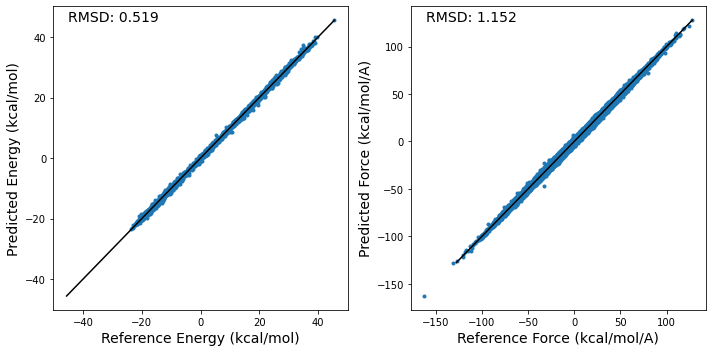

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy.cpu().detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
e2 = ene_pred.detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_pred.detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
descriptor.local_embedding.0.weight 	 torch.Size([9, 25, 1])
descriptor.local_embedding.0.bias 	 torch.Size([9, 25])
descriptor.local_embedding.1.weight 	 torch.Size([9, 50, 25])
descriptor.local_embedding.1.bias 	 torch.Size([9, 50])
descriptor.local_embedding.2.weight 	 torch.Size([9, 100, 50])
descriptor.local_embedding.2.bias 	 torch.Size([9, 100])
fitting_net.fitting_net.0.weight 	 torch.Size([3, 240, 400])
fitting_net.fitting_net.0.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.1.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.1.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.2.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.2.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.3.weight 	 torch.Size([3, 1, 240])
fitting_net.fitting_net.3.bias 	 torch.Size([3, 1])


1575
500


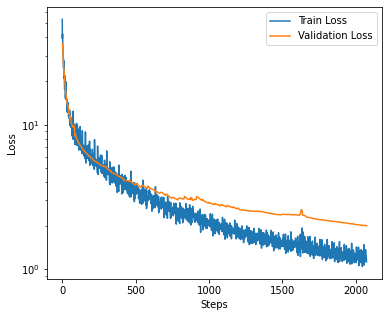

In [ ]:
import pandas as pd

data = pd.read_csv('logs_csv/lightning_logs/version_0/metrics.csv')
# data = pd.read_csv('/content/drive/MyDrive/f10_e500/logs_csv/lightning_logs/version_2/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Train Loss')
y = data['val_loss'][~data['val_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png', dpi=300)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')